## ARIMA/SARIMAX, Prophet, Bagging/Boosting & Pycaret Performance Comparison

### REGION: us-east-1 --> instance = r5d.4xlarge, OS-type = SUSE Linux, sub-region = us-east-1a

**Author: Sumaia Parveen Shupti, Siti Khotijah, Clementine Yarjah**

Updated on: 04/29/2021


* Used hourly sampled data for each algorithm
* Train set timeframe (02/15/2021-04/15/2021)
* Test set timeframe: 16th & 17th April

#### Highlight: Only SARIMAX can be applicable, other algorithms fail to provide  R2 value


In [1]:
#!pip install prophet 
#!pip install pycaret

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import prediction_error
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

from sklearn.model_selection import cross_val_score, cross_validate, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, cross_val_predict
from xgboost import XGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, BaggingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.tree import ExtraTreeRegressor
from lightgbm.sklearn import LGBMRegressor

import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns

from subprocess import check_output

import itertools
plt.style.use('seaborn')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 11
matplotlib.rcParams['ytick.labelsize'] = 11
matplotlib.rcParams['text.color'] = 'k'
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams['lines.linewidth'] = 2
import matplotlib.dates as mdates

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook
from itertools import product

### Data Preprocessing

In [3]:
df = pd.read_csv("../input/aws-spot-price-15th-feb16th-april-2021/us-east-1_Feb15-Apr16.csv")

import datetime as dt
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f', utc=True)
df = df.sort_values(by="Timestamp")

df = df[(df.AvailabilityZone == 'us-east-1a') & (df.InstanceType == 'r5d.4xlarge') & (df.ProductDescription == 'SUSE Linux')]
df = df[['Timestamp', 'SpotPrice']]

df = df.set_index('Timestamp').resample('60T').mean()
df['SpotPrice'].fillna(method='ffill',inplace=True)
print (df.shape)
df.head()

(1443, 1)


,SpotPrice
Timestamp,
2021-02-16 01:00:00+00:00,0.486
2021-02-16 02:00:00+00:00,0.486
2021-02-16 03:00:00+00:00,0.486
2021-02-16 04:00:00+00:00,0.486
2021-02-16 05:00:00+00:00,0.486


## ARIMA/SARIMAX

### Parameters and Modelling

In [4]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [5]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            warnings.filterwarnings('ignore')
        except:
            continue

In [6]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4635      0.013     36.646      0.000       0.439       0.488
ma.L1         -0.4548      0.013    -36.032      0.000      -0.480      -0.430
ar.S.L12      -0.5197      0.009    -59.151      0.000      -0.537      -0.503
sigma2      2.553e-06   3.21e-08     79.572      0.000    2.49e-06    2.62e-06


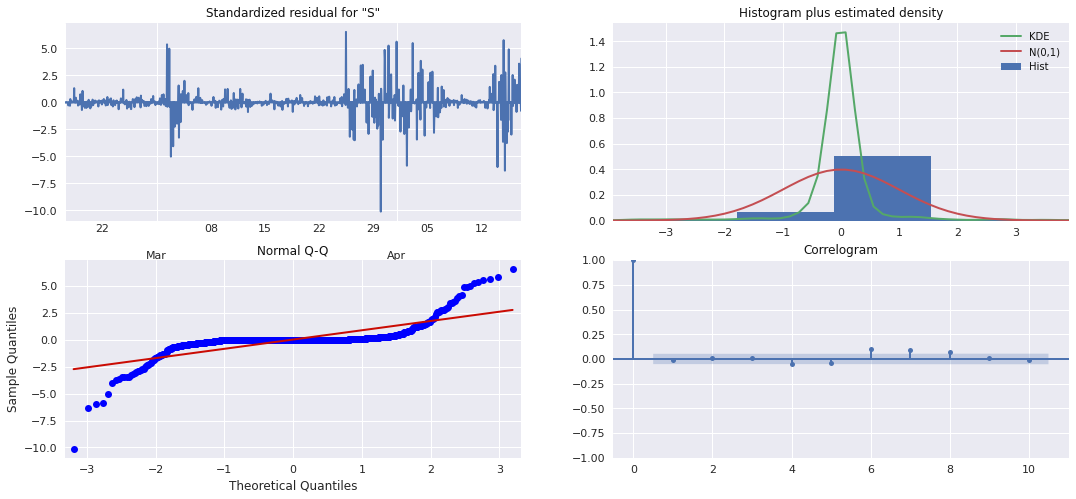

In [7]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

### Prediction

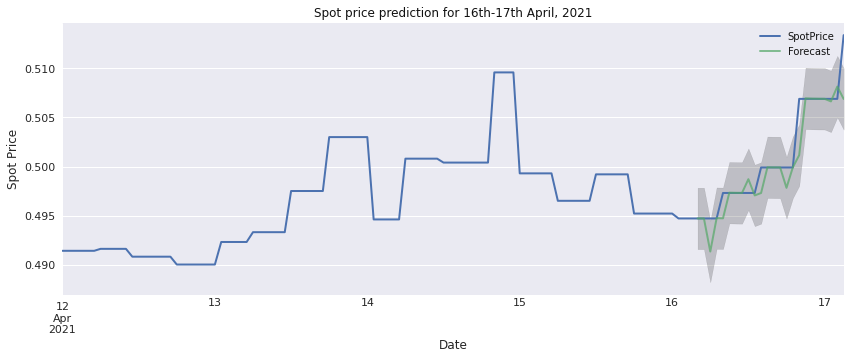

In [8]:
pred = results.get_prediction(start=pd.to_datetime('2021-04-16').tz_localize('US/Eastern'), dynamic=False)
pred_ci = pred.conf_int()

ax = df['2021-04-12':].plot(label='observed', linewidth = 2)
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 5), linewidth = 2)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Spot Price')
plt.legend()
plt.title('Spot price prediction for 16th-17th April, 2021')

plt.show()

### Evaluation Metrics

In [9]:
y_pred = pred.predicted_mean
y_test = df['2021-04-16 04:00:00':]

# Compute the mean square error
mse = ((y_pred - y_test.SpotPrice) ** 2).mean()

def maped(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape = maped(y_test, y_pred)

Algorithm = []
MAE = []
MSE = []
RMSE = []
MAPE = []
R2 = []

Algorithm.append('SARIMAX')
MAE.append(round(mean_absolute_error(y_test, y_pred), 4))
MSE.append(round(mse, 4))
RMSE.append(round(np.sqrt(mse), 4))
MAPE.append(round(mape, 4))
R2.append(round(r2_score(y_test, y_pred), 4))


In [10]:
print ('The Mean Absolute Error (MAE): {}'.format(round(mean_absolute_error(y_test, y_pred), 4)))
print('The Mean Squared Error (MSE): {}'.format(round(mse, 4)))
print('The Root Mean Squared Error  (RMSE): {}'.format(round(np.sqrt(mse), 4)))
print('The Mean Absolute Percentage Error (MAPE) {}'.format(round(mape, 4)))

print('The R2 value: {}'.format(round(r2_score(y_test, y_pred), 4)))

The Mean Absolute Error (MAE): 0.0011
The Mean Squared Error (MSE): 0.0
The Root Mean Squared Error  (RMSE): 0.0021
The Mean Absolute Percentage Error (MAPE) 1.1104
The R2 value: 0.8324


## Prophet

### Data Preprocessing

In [11]:
df_proph = df.reset_index()
df_proph.columns = ['ds', 'y']
df_proph['ds'] = df_proph['ds'].dt.tz_convert(None)
print (df_proph.shape)
df_proph.head()

(1443, 2)


,ds,y
0,2021-02-16 01:00:00,0.486
1,2021-02-16 02:00:00,0.486
2,2021-02-16 03:00:00,0.486
3,2021-02-16 04:00:00,0.486
4,2021-02-16 05:00:00,0.486


### Modelling

In [12]:
#!pip install prophet 
from prophet import Prophet

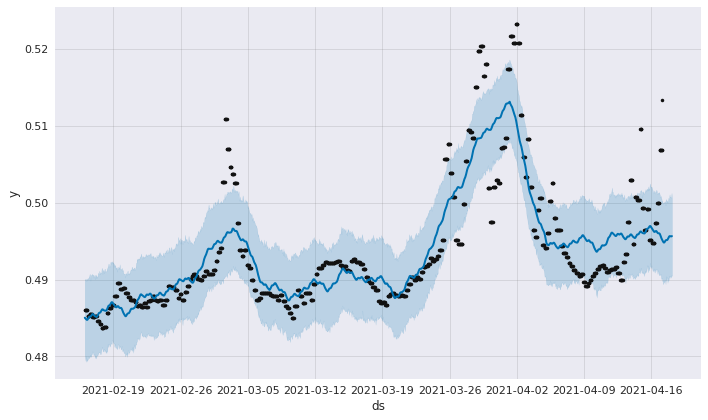

In [13]:
m = Prophet(changepoint_prior_scale=0.01).fit(df_proph)
future = m.make_future_dataframe(periods=24, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

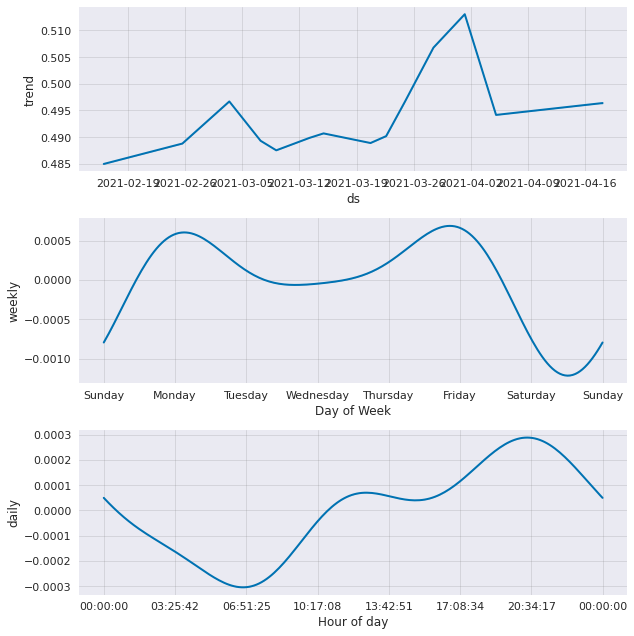

In [14]:
fig = m.plot_components(fcst)

In [15]:
y_hat = fcst.set_index('ds')
y_pred = y_hat[1415:1443].yhat

y_t=df_proph.set_index('ds')
y_test = y_t.y[1415:]

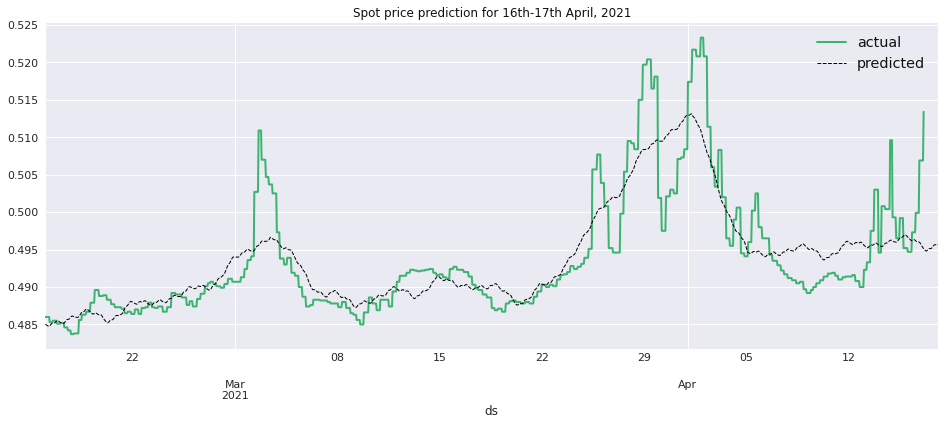

In [16]:
plt.rcParams["figure.figsize"] = [16, 6]

y_t.y.plot(linewidth = 2, label = 'actual', color = 'mediumseagreen')
y_hat.yhat.plot(linewidth = 1, label = 'predicted', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.title('Spot price prediction for 16th-17th April, 2021')
plt.show()

### Evaluation Metrics

In [17]:
# Compute the mean square error
mse = ((y_pred - y_test) ** 2).mean()

mape = maped(y_test, y_pred)

Algorithm.append('Prophet')
MAE.append(round(mean_absolute_error(y_test, y_pred), 4))
MSE.append(round(mse, 4))
RMSE.append(round(np.sqrt(mse), 4))
MAPE.append(round(mape, 4))
R2.append(round(r2_score(y_test, y_pred), 4))

print ('The Mean Absolute Error (MAE): {}'.format(round(mean_absolute_error(y_test, y_pred), 4)))
print('The Mean Squared Error (MSE): {}'.format(round(mse, 4)))
print('The Root Mean Squared Error  (RMSE): {}'.format(round(np.sqrt(mse), 4)))
print('The Mean Absolute Percentage Error (MAPE) {}'.format(round(mape, 4)))

print('The R2 value: {}'.format(round(r2_score(y_test, y_pred), 4)))

The Mean Absolute Error (MAE): 0.005
The Mean Squared Error (MSE): 0.0
The Root Mean Squared Error  (RMSE): 0.0069
The Mean Absolute Percentage Error (MAPE) 0.9901
The R2 value: -0.7299


## Comparison of Prophet & SARIMAX

In [18]:
compare = pd.DataFrame({'Algorithm' : Algorithm , 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE, 'R2': R2})

compare

,Algorithm,MAE,MSE,RMSE,R2
0,SARIMAX,0.0011,0.0,0.0021,0.8324
1,Prophet,0.0050,0.0,0.0069,-0.7299


## Performance of Bagging & Boosting Regression

### Data Preprocessing

In [19]:
df_bb = df.copy()

df_bb['Date'] = df_bb.index.date
df_bb['Date'] = pd.to_datetime(df_bb['Date'])

df_bb['Year'] = df_bb.index.year
df_bb['Month'] = df_bb.index.month
df_bb['Day'] = df_bb.index.day
df_bb['Hour'] = df_bb.index.hour

# Convert the date into a number (of days since some point)
fromDate = min(df.index)
df_bb['Timedelta'] = (df.index - fromDate).astype(np.int64)/100000000000

df_bb = df_bb.reset_index(drop = True)

print (df_bb.shape)

df_bb.head()


(1443, 7)


,SpotPrice,Date,Year,Month,Day,Hour,Timedelta
0,0.486,2021-02-16,2021,2,16,1,0.0
1,0.486,2021-02-16,2021,2,16,2,36.0
2,0.486,2021-02-16,2021,2,16,3,72.0
3,0.486,2021-02-16,2021,2,16,4,108.0
4,0.486,2021-02-16,2021,2,16,5,144.0


### Train-Test Split

In [20]:
def train_test_split(df):
    
    # Train Data
    start_date = '2021-02-13'
    end_date = '2021-04-14'

    mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
    train = df.loc[mask]
    train_ = train.copy()
    train.drop('Date', axis = 1, inplace = True)

    # Test Data
    start_date = '2021-04-14'
    end_date = '2021-04-16'

    mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
    test = df.loc[mask]
    test_ = test.copy()
    test.drop('Date', axis = 1, inplace = True)
    
    # Train-Test Split
    X_train = train.drop('SpotPrice', axis = 1) 
    y_train = train['SpotPrice']

    X_test = test.drop('SpotPrice', axis = 1) 
    y_test = test['SpotPrice']
    
    # Scaling
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    return X_train, X_test, y_train, y_test, train_, test_

### Evaluation Metrics

In [21]:
def model_comparison(df, models =[], model_names= []):
    
    X_train, X_test, y_train, y_test, train_, test_ = train_test_split(df)

    mean_absolute_error = []
    mean_squared_error = []
    root_mean_squared_error = []
    mape = []
    r_squared = []
    adjusted_r_squared = []
    
    for model in range(len(models)):
        regressor = models[model]
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        y_pred_train = regressor.predict(X_train)

        mean_squared_error.append(round(metrics.mean_squared_error(y_test, y_pred), 4))
        root_mean_squared_error.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 4))
        r_squared.append(round(metrics.r2_score(y_test, y_pred), 4))
        adjusted_r_squared.append(round(1 - (1- metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1), 4))
        mean_absolute_error.append(round(metrics.mean_absolute_error(y_test, y_pred), 4))
        mape.append(maped(y_test, y_pred))
        
    compare = pd.DataFrame({'Algorithm' : model_names , 'MAE': mean_absolute_error, 'MSE': mean_squared_error, \
                            'RMSE': root_mean_squared_error, 'MAPE': mape, 'R2': r_squared, 'Adjusted R2': adjusted_r_squared})
    return compare

### Algorithms we'll look at

In [22]:
models = [AdaBoostRegressor(), BaggingRegressor(), RandomForestRegressor(),  BaggingRegressor(RandomForestRegressor()), XGBRegressor(),
        GradientBoostingRegressor(), CatBoostRegressor(logging_level='Silent'), ExtraTreeRegressor(), LGBMRegressor(), HistGradientBoostingRegressor(),\
         MLPRegressor(), DecisionTreeRegressor(), KNeighborsRegressor()]

model_names=['AdaBoostRegressor','BaggingRegressor', 'RandomForestRegressor', 'BaggingRFRegressor', 'XGBoostRegressor',
             'GradientBoostingRegressor', 'CatBoostRegressor', 'ExtraTreeRegressor', 'LGBMRegressor', 'HistGradientBoostingRegressor', 'MLPRegressor',\
            'DecisionTreeRegressor', 'KNeighborsRegressor']

In [23]:
%%time 

from datetime import datetime

# We provide the regional-DataFrames here
import sklearn.metrics as metrics
comp = model_comparison(df_bb, models, model_names)

comp.sort_values("MAPE",inplace=True)
comp = comp.reset_index(drop = True)
comp


CPU times: user 11.2 s, sys: 2.31 s, total: 13.5 s
Wall time: 6.34 s


,Algorithm,MAE,MSE,RMSE,MAPE,R2,Adjusted R2
0,KNeighborsRegressor,0.0028,0.0000,0.0043,0.565079,-0.7419,-0.9493
1,HistGradientBoostingRegressor,0.0034,0.0000,0.0041,0.680136,-0.6148,-0.8070
2,CatBoostRegressor,0.0034,0.0000,0.0050,0.683633,-1.3464,-1.6257
3,LGBMRegressor,0.0034,0.0000,0.0042,0.693003,-0.7183,-0.9229
4,AdaBoostRegressor,0.0041,0.0000,0.0045,0.814596,-0.9117,-1.1393
5,ExtraTreeRegressor,0.0044,0.0000,0.0059,0.877172,-2.3124,-2.7067
6,XGBoostRegressor,0.0056,0.0000,0.0066,1.133093,-3.0978,-3.5856
7,BaggingRFRegressor,0.0061,0.0000,0.0068,1.222711,-3.3944,-3.9176
8,RandomForestRegressor,0.0094,0.0001,0.0099,1.895385,-8.3264,-9.4367
9,GradientBoostingRegressor,0.0102,0.0001,0.0106,2.043710,-9.7865,-11.0706


## Performance of Pycaret Time-Series 

### Data Preprocessing

In [24]:
# Train Data
start_date = '2021-02-13'
end_date = '2021-04-14'

mask = (df_bb['Date'] > start_date) & (df_bb['Date'] <= end_date)
train = df_bb.loc[mask]
train.drop('Date', axis = 1, inplace = True)

# Test Data
start_date = '2021-04-14'
end_date = '2021-04-16'

mask = (df_bb['Date'] > start_date) & (df_bb['Date'] <= end_date)
test = df_bb.loc[mask]
test.drop('Date', axis = 1, inplace = True)

In [25]:
#!pip install pycaret

In [26]:
# import the regression module
from pycaret.regression import *

# initialize setup
s = setup(data = train, test_data = test, target = 'SpotPrice', fold_strategy = 'timeseries', numeric_features = ['Year', 'Month', 'Day', 'Hour', 'Timedelta'], fold = 5, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,SpotPrice
2,Original Data,"(1391, 6)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1391, 5)"


In [27]:
best = compare_models(sort = 'MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0048,0.0001,0.0059,-0.6193,0.0040,0.0094,0.7120
lightgbm,Light Gradient Boosting Machine,0.0051,0.0001,0.0067,-0.4823,0.0045,0.0102,0.2360
gbr,Gradient Boosting Regressor,0.0052,0.0001,0.0068,-0.5207,0.0046,0.0104,0.0400
knn,K Neighbors Regressor,0.0053,0.0001,0.0069,-0.5640,0.0046,0.0105,0.6580
ada,AdaBoost Regressor,0.0054,0.0001,0.0070,-0.6176,0.0047,0.0107,0.0320
rf,Random Forest Regressor,0.0056,0.0001,0.0072,-0.6579,0.0048,0.0110,0.2260
et,Extra Trees Regressor,0.0056,0.0001,0.0072,-0.6658,0.0048,0.0111,0.2060
dt,Decision Tree Regressor,0.0057,0.0001,0.0073,-0.7090,0.0049,0.0113,0.0160
llar,Lasso Least Angle Regression,0.0063,0.0001,0.0082,-1.0502,0.0055,0.0124,0.6060
xgboost,Extreme Gradient Boosting,0.1031,0.0486,0.1042,-1418.8376,0.0839,0.2091,8.5300


**Conclusion** : None of the models were chosen for final implementation. 